In [2]:
## Upload datasets ## 
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import iqr
from collections import Counter
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
## Import datasets
training_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv" )

In [4]:
## Display data
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
## Shape of training and testing datasets

print("Training dataset : " , training_data.shape)
print("Testing dataset : ", test_data.shape)

Training dataset :  (891, 12)
Testing dataset :  (418, 11)


In [6]:
## Data types 
training_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
## Descriptives statistics -- Numerical data
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
## Descriptive statistics -- Categorical data 
training_data.describe(include = 'O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Sunderland, Mr. Victor Francis",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [7]:
## Check missing values ## 
print("Training dataset Missing Values : \n ")
print(training_data.isnull().sum())
print("-"*40 + "\n")
print("Test dataset Missing Values : \n ")
print(test_data.isnull().sum())

Training dataset Missing Values : 
 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------

Test dataset Missing Values : 
 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
### Before we dive into the data analysis/preprocessing, I decide to remove outliers at first ###

## Function to detect outliers ##
## We use the IQR principle to detect outliers
## outliers must be greater  than Q3 + 1.5*IQR or less than Q1 -1.5*IQR
def detect_outliers(data_frame,col):

    # List containing index of outliers
    L_index = []

    # Convert Series to Array
    col_array = np.asarray(data_frame[col])

    ## Compute first quartile
    Q1 = np.percentile(a = data_frame[col], q = 25)
    ## Compute third quartile
    Q3 = np.percentile(a = data_frame[col], q = 75)
    ## Compute Inter-Quartile
    IQR = Q3 - Q1 ## or IQR = Q3-Q1

    ## Threshold
    threshold_max = Q3 + 1.5*IQR
    threshold_min = Q1 - 1.5*IQR

    for i in range(len(col_array)):
      if col_array[i]>threshold_max or col_array[i] < threshold_min:
        L_index.append(i)
    
    return L_index

## Outliers for "Fare, Age, SibSp, Parch Features "
L_index_fare = detect_outliers(training_data,"Fare")
L_index_age = detect_outliers(training_data,"Age")
L_index_SibSp = detect_outliers(training_data,"SibSp")
L_index_Parch = detect_outliers(training_data,"Parch")

## Concat outliers index
L_concat = L_index_fare + L_index_age + L_index_SibSp + L_index_Parch

## Convert to dictionnary
dict_index = Counter(L_concat)

## We will just keep sample who has more than 2 outliers ##
L_index_outliers = [i for i,j in dict_index.items() if j>2]
print("Index of outliers  : ",sorted(L_index_outliers))


Index of outliers  :  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [6]:
## Visualize the outliers to remove from the dataframe #
training_data.loc[L_index_outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [7]:
## Drop outliers rows ##
training_data.drop(L_index_outliers,inplace = True)

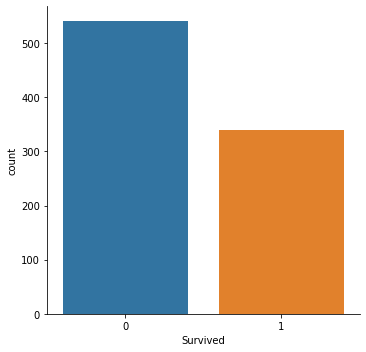

In [8]:
## Number of each classes
## => Skewed classes 
sns.catplot(x = "Survived" , kind = "count" , data = training_data)

**Data Wrangling**

In [9]:
## Drop duplicates rows if it exists
training_data.drop_duplicates(inplace = True)

In [10]:
## Drop Column Cabin 
training_data.drop(columns = ["Cabin"] , inplace = True)
test_data.drop(columns = ["Cabin"] , inplace = True)

In [11]:
## Add feature "IsAlone" if the passenger is Alone aboard the titanic 

## Training data
training_data["Family"] = training_data["SibSp"] + training_data["Parch"] + 1
training_data["IsAlone"] = training_data["Family"].apply(lambda x : 1 if x == 1 else 0)

## Test data
test_data["Family"] = test_data["SibSp"] + test_data["Parch"] + 1
test_data["IsAlone"] = test_data["Family"].apply(lambda x : 1 if x == 1 else 0)

In [12]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,1


In [13]:
## Drop Column Ticket
## According to statistics description column Ticket has more than 200 passenger with the same tickets 
## Which is not correct.
training_data.drop(columns = ["Ticket"] ,inplace = True)
test_data.drop(columns = ["Ticket"] , inplace = True)

In [14]:
## Replace missing values in Age by median due to presence of outliers ##
mean_age = training_data[["Age"]].median()
training_data[["Age"]] = training_data[["Age"]].fillna(mean_age ,inplace = False)

mean_age_testdata = test_data[["Age"]].median()
test_data[["Age"]] = test_data[["Age"]].fillna(mean_age_testdata, inplace = False)

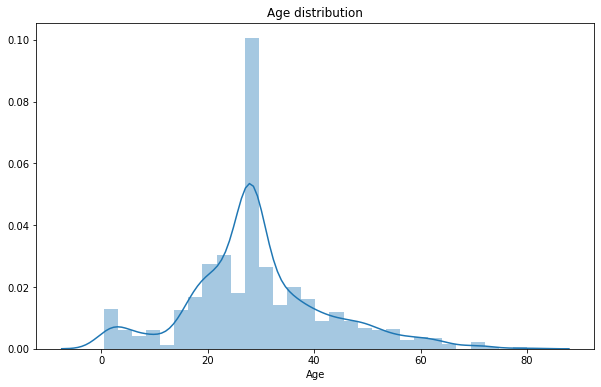

In [15]:
## Age distribution => Normal distribution
plt.figure(figsize = (10,6))
plt.title("Age distribution")
sns.distplot(training_data["Age"])

In [16]:
## Binning age may improve the accuracy of our model
## I chose 4 intervals 

## Training data
bins = [min(training_data["Age"]),20,45,60,max(training_data["Age"])]
group_label = [0,1,2,3]
training_data["Age_binned"] = pd.cut(training_data["Age"],bins , labels = group_label,include_lowest=True) 

## test data
bins_test = [min(test_data["Age"]),20,45,60,max(test_data["Age"])]
test_data["Age_binned"] = pd.cut(test_data["Age"],bins_test , labels = group_label,include_lowest=True) 


In [17]:
## Missing data in "Fare" from test data
## Impute the missing data by median
mean_fare_testdata = test_data[["Fare"]].median()
test_data[["Fare"]] = test_data[["Fare"]].fillna(mean_fare_testdata , inplace = False)

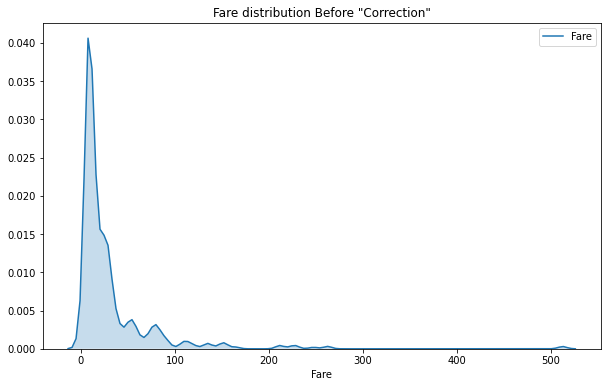

In [18]:
## Distribution of column "Fare"
plt.figure(figsize = (10,6))
plt.title("Fare distribution Before \"Correction\"")
plt.xlabel("Fare")
sns.kdeplot(data = training_data["Fare"] , shade = True)

## Conclusion : Skewed distribution 

In [19]:
## Apply LOG to remove skewness from "Fare" distribution
training_data["Fare"] = training_data["Fare"].apply(lambda x : math.log10(abs(x)) if x != 0 else x)
test_data["Fare"] = test_data["Fare"].apply(lambda x : math.log10(abs(x)) if x != 0 else x)

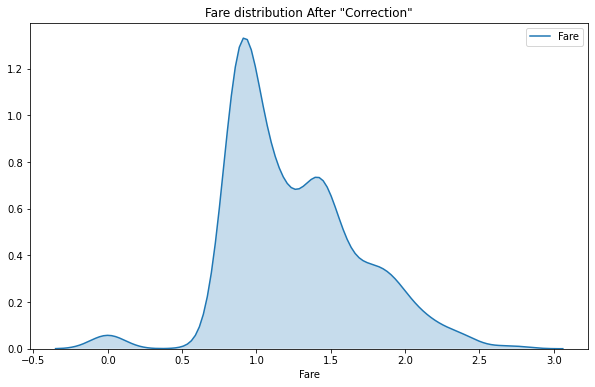

In [20]:
## Distribution of column "Fare" after correction
plt.figure(figsize = (10,6))
plt.title("Fare distribution After \"Correction\"")
plt.xlabel("Fare")
sns.kdeplot(data = training_data["Fare"] , shade = True)

In [21]:
## Number of passengers Embarked per each Gate
training_data[["Embarked","PassengerId"]].groupby("Embarked").count()

## Conclusion : Number of Passengers embarked from gata "S" are greater than the other boarding gate

,PassengerId
Embarked,
C,168
Q,77
S,634


In [22]:
## Impute missing values for Embarked in the Training data ##
## Based on the conclusion above, we are going to impute missing values in column Embarked by the boarding gate "S" ( the most frequent one)
training_data[["Embarked"]] = training_data[["Embarked"]].fillna("S")

Text(0.5, 0, 'Boarding gate')

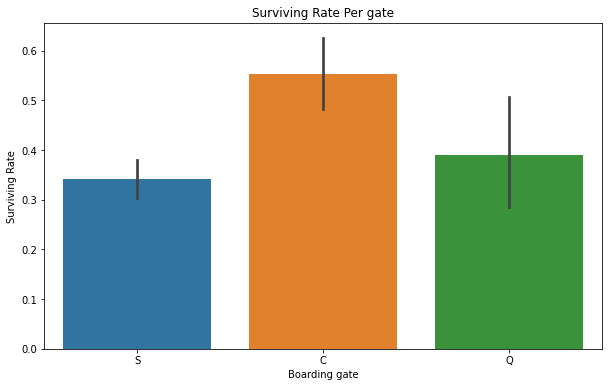

In [23]:
## Barplot to show relation between embarked and our target variable : Survived
plt.figure(figsize = (10,6))
plt.title("Surviving Rate Per gate")
sns.barplot(x = training_data["Embarked"] , y = training_data["Survived"])
plt.ylabel("Surviving Rate")
plt.xlabel("Boarding gate")

## Conclusion : Passengers who embarked from gate "C" are most likely to survive

In [24]:
## One hot encoding for Embarked ## 

def one_hot_encoding(data_frame,categ_col):

  hot_encoder = OneHotEncoder(handle_unknown="ignore",sparse = False)
  cols_train = pd.DataFrame(hot_encoder.fit_transform(data_frame[[categ_col]]))


  cols_train.columns = hot_encoder.get_feature_names([categ_col])
  cols_train.index = data_frame.index

  num_train = data_frame.drop([categ_col], axis = 1)

  hot_encoder_train = pd.concat([num_train,cols_train] , axis  = 1)

  return hot_encoder_train


## Encoding column "Embarked" using OnehotEncoding
training_data = one_hot_encoding(training_data,"Embarked")
test_data = one_hot_encoding(test_data,"Embarked")

In [25]:
## Feature "Name"
## Adding new Feature "Formal_name" extracted from column "Name" using Regular Expression ##

def reg_extract(data_frame):
  """
  Argument : Dataframe
  Return : A new Dataframe with column "Formal_names" extracted from "Names" column
  """
  L_name = list(data_frame["Name"])
  L_regex = []
  data_frame['Formal_names'] = data_frame.Name.str.extract(r"\,(.*?)\.", expand=False)
  return data_frame



training_data = reg_extract(training_data)
test_data = reg_extract(test_data)

In [26]:
## Crosstab "Sex" and "Formal_names"
pd.crosstab(training_data["Sex"],training_data["Formal_names"])

Formal_names,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,177,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,39,0,0,0,513,0,0,6,1,0


In [27]:
pd.crosstab(test_data["Sex"],test_data["Formal_names"])

Formal_names,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


In [28]:
## Replace female formal names by "Mrs"
training_data["Formal_names"].replace([" Mlle"," Mme"," Miss"," Lady"," Ms"]," Mrs" ,inplace = True)
test_data["Formal_names"].replace([" Miss"," Ms"]," Mrs" ,inplace = True)

In [29]:
## Encoding "Formal_names" column

def categ_Formal_name(x):
  if x == " Mr":
    return 1
  elif x == " Mrs":
    return 2
  elif x == " Master":
    return 3
  elif x == " Dr":
    return 4
  else : 
    return 0

## From categorical to numerical feature
training_data["Formal_names"] = training_data["Formal_names"].apply(lambda x : categ_Formal_name(x) )
test_data["Formal_names"] = test_data["Formal_names"].apply(lambda x : categ_Formal_name(x) )

In [30]:
## Convert Column Sex from categorical feature to numerical feature ##
training_data["Sex"] = training_data["Sex"].apply(lambda x : 1 if x == "male" else 0)
test_data["Sex"] = test_data["Sex"].apply(lambda x : 1 if x == "male" else 0)

In [31]:
## Display training data
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Family,IsAlone,Age_binned,Embarked_C,Embarked_Q,Embarked_S,Formal_names
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0.860338,2,0,1,0.0,0.0,1.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,1.852988,2,0,1,1.0,0.0,0.0,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,0.898999,1,1,1,0.0,0.0,1.0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,1.725095,2,0,1,0.0,0.0,1.0,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,0.905796,1,1,1,0.0,0.0,1.0,1


In [56]:
## Display Test data
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Family,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Formal_names,Age_binned
0,892,3,"Kelly, Mr. James",1,34.5,0,0,0.893717,1,1,0.0,1.0,0.0,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,0.845098,2,0,0.0,0.0,1.0,2,2
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,0.986212,1,1,0.0,1.0,0.0,1,3
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,0.937643,1,1,0.0,0.0,1.0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,1.089464,3,0,0.0,0.0,1.0,2,1


In [32]:
## Check training/test data types
training_data.dtypes

PassengerId        int64
Survived           int64
Pclass             int64
Name              object
Sex                int64
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Family             int64
IsAlone            int64
Age_binned      category
Embarked_C       float64
Embarked_Q       float64
Embarked_S       float64
Formal_names       int64
dtype: object

In [33]:
## Convert "Age_binned" from category to numerical feature
test_data["Age_binned"] = test_data["Age_binned"].astype("int")
training_data["Age_binned"] = training_data["Age_binned"].astype("int")

In [34]:
## I chose to add those features to improve accuracy
## This features was added after implementing the model the first time and trying to do "Error Analysis"  

training_data["Embarked_Q_Alone"] = training_data["Embarked_Q"] + training_data["IsAlone"]
training_data["Embarked_Q_Alone"] = training_data["Embarked_Q_Alone"].apply(lambda x : 1 if int(x) == 2 else 0)

In [35]:
training_data["Age_binned_range2"] = training_data["Age_binned"].apply(lambda x : 1 if x == 1 else 0)
test_data["Age_binned_range2"] = test_data["Age_binned"].apply(lambda x : 1 if x == 1 else 0)

In [36]:
test_data["Embarked_Q_Alone"] = test_data["Embarked_Q"] + test_data["IsAlone"]
test_data["Embarked_Q_Alone"] = test_data["Embarked_Q_Alone"].apply(lambda x : 1 if int(x) == 2 else 0)

In [37]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Family,IsAlone,Age_binned,Embarked_C,Embarked_Q,Embarked_S,Formal_names,Embarked_Q_Alone,Age_binned_range2
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0.860338,2,0,1,0.0,0.0,1.0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,1.852988,2,0,1,1.0,0.0,0.0,2,0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,0.898999,1,1,1,0.0,0.0,1.0,2,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,1.725095,2,0,1,0.0,0.0,1.0,2,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,0.905796,1,1,1,0.0,0.0,1.0,1,0,1


In [38]:
X  =  training_data[["Age","SibSp" ,"Sex","Parch","Fare","IsAlone","Embarked_C","Embarked_Q","Embarked_S","Pclass","Formal_names","Age_binned","Embarked_Q_Alone","Age_binned_range2"]]
y  = training_data["Survived"]

In [40]:
X.dtypes

Age                  float64
SibSp                float64
Sex                  float64
Parch                float64
Fare                 float64
IsAlone              float64
Embarked_C           float64
Embarked_Q           float64
Embarked_S           float64
Pclass               float64
Formal_names         float64
Age_binned           float64
Embarked_Q_Alone     float64
Age_binned_range2    float64
dtype: object

In [39]:
## Normalize data
cols = list(X.columns)
for col in cols:
  X[col] = X[col] / X[col].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [41]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

### Function to plot learning curves
### Adapted from scikit-learn documentation : https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html ####

def plot_learning_curves(estimator,title,X,y,axes = None,ylim = None,cv = None,n_jobs = None,train_sizes = np.linspace(.1,1.0,5)):
  if axes is None:
    _,axes = plt.subplots(1,2,figsize = (20,8))

  if ylim is not None:
    axes[0].set_ylim(*ylim)

  axes[0].set_title(title)
  axes[0].set_xlabel("Training Examples")
  axes[0].set_ylabel("Score")

  ## Learning curves corresponding to the training/validation accuracy 
  train_sizes,train_scores,test_scores,fit_times,_ = learning_curve(estimator,X,y,cv = cv,n_jobs=n_jobs,train_sizes = train_sizes,return_times =True,scoring = "f1")
  train_scores_mean  = np.mean(train_scores,axis = 1)
  train_scores_std = np.std(train_scores,axis = 1)
  test_scores_mean = np.mean(test_scores,axis = 1)
  test_scores_std = np.std(test_scores,axis = 1)

  ## Learning curves corresponding to the training/validation error

  train_sizes,train_error,test_error,fit_times,_  = learning_curve(estimator,X,y,cv = cv ,
                                                    n_jobs = n_jobs,train_sizes = train_sizes,
                                                    return_times = True , scoring = "neg_log_loss")

  train_error_mean = -np.mean(train_error, axis = 1)
  train_error_std = -np.std(train_error, axis = 1)
  test_error_mean = -np.mean(test_error, axis = 1)
  test_error_std = -np.std(test_error , axis = 1)

  ## plot learning curves corresponding to accuracy

  axes[0].grid()
  axes[0].fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha = 0.1,color = "r")
  axes[0].fill_between(train_sizes,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std,alpha = 0.1,color = "g")
  axes[0].plot(train_sizes,train_scores_mean,'o-',color ="r",label = "Training scores")
  axes[0].plot(train_sizes,test_scores_mean,"o-",color = "g",label = "Cross-validation score")
  axes[0].legend(loc = "best")

  ## plot learning curves corresponding to error

  axes[1].set_xlabel("Training examples")
  axes[1].set_title("Learning curves Error")

  axes[1].grid()
  axes[1].fill_between(train_sizes,train_error_mean-train_error_std,train_error_mean+train_error_std,alpha = 0.1,color = "r")
  axes[1].fill_between(train_sizes,test_error_mean-test_error_std,test_error_mean+test_error_std,alpha = 0.1,color = "g")
  axes[1].plot(train_sizes,train_error_mean,'o-',color ="r",label = "Training error")
  axes[1].plot(train_sizes,test_error_mean,"o-",color = "g",label = "Cross-validation error")
  axes[1].legend(loc = "best")


  return plt



In [42]:
## Import ML algorithm / Metrics
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error,accuracy_score,f1_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import LogisticRegression

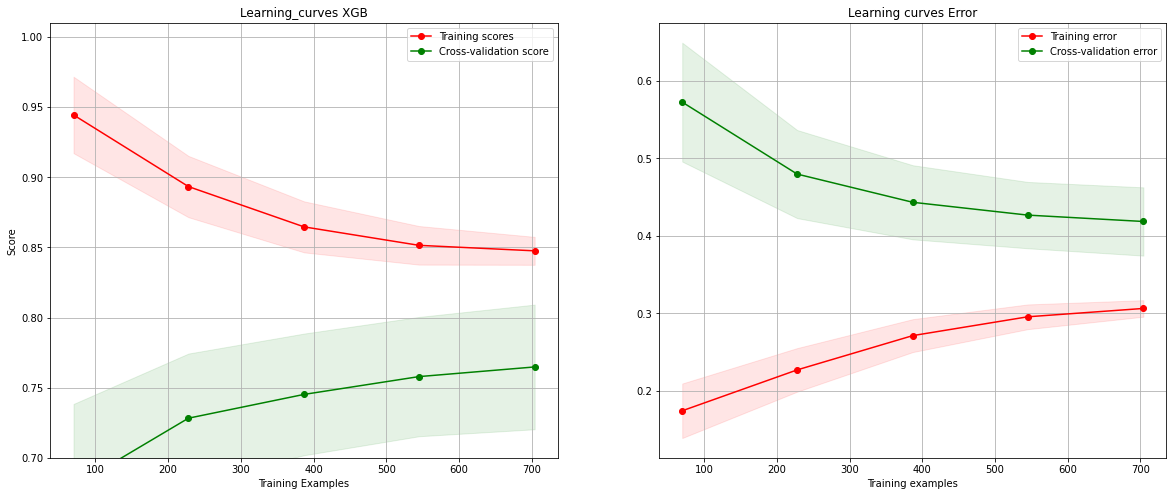

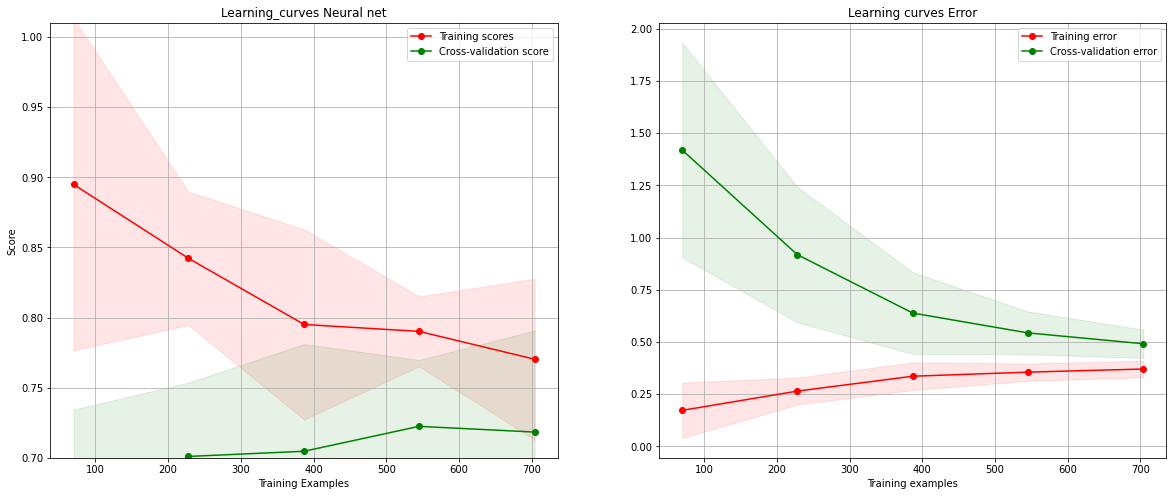

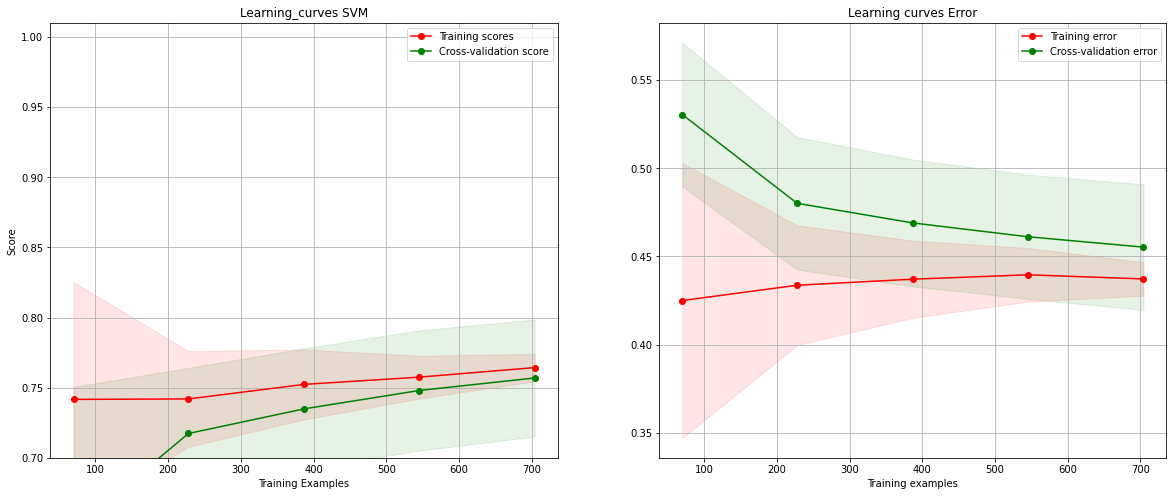

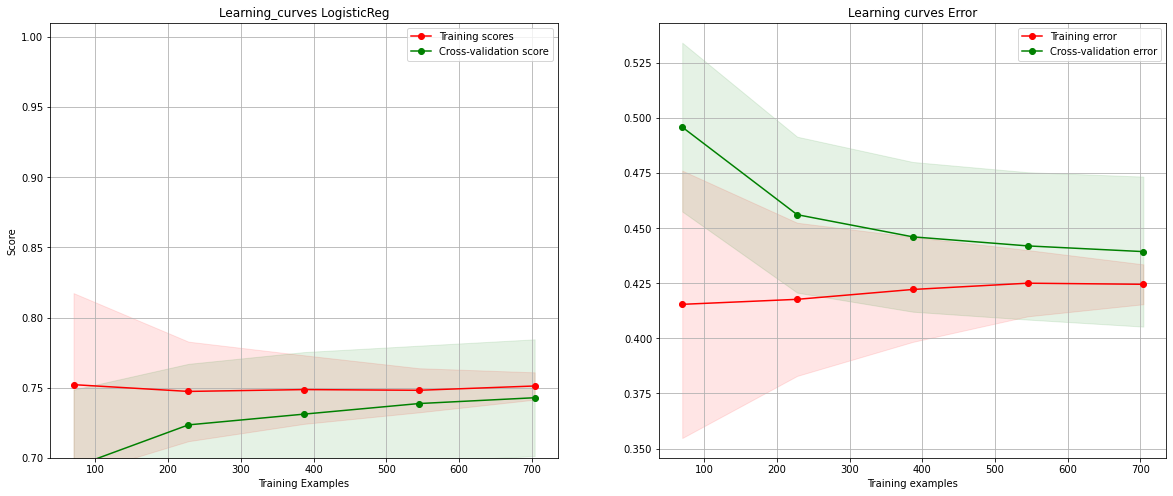

In [43]:

## Different models 

## Xgboost with default parameters
XGB = XGBClassifier()

## Logistic Regression
Reglog = LogisticRegression(random_state = 42 ,C = 1.5)

## SVM with gaussian kernel
SVM = SVC(kernel = "rbf",random_state = 0,probability=True , C = 0.6)

## Neural net with two hidden layers of 10 and 8 dense units
ANN = MLPClassifier(solver = "lbfgs",hidden_layer_sizes=(10,8),alpha = 0.1 ,early_stopping=True,random_state=42)
ANN.out_activation_ = "sigmoid" ## sigmoid activation ( binary classification model)


## Cross-validation , with 80% for training set and 20% for test set
cv = ShuffleSplit(n_splits=100,test_size = 0.2,random_state = 0)

## Plot learning curves for each model

## Learning curves xgboost
title_XGB = "Learning_curves XGB"
plot_learning_curves(XGB, title_XGB, X, y, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

## Learning curves Neural network
title_ANN = "Learning_curves Neural net"
plot_learning_curves(ANN, title_ANN, X, y, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

## Learning curves SVC
title_SVM = "Learning_curves SVM"
plot_learning_curves(SVM, title_SVM, X, y, ylim=(0.7, 1.01),
                     cv=cv, n_jobs=4)

## Learning curves Logistic Regression
title_reg = "Learning_curves LogisticReg"
plot_learning_curves(Reglog, title_reg, X, y, ylim=(0.7, 1.01),
                     cv=cv, n_jobs=4)

## display curves
plt.show()

In [44]:
## Split the data into validation and test set
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2, random_state = 0)

## Fitting the best model
Reglog.fit(X_train,y_train)

y_val_pred = Reglog.predict(X_val)
print(f1_score(y_val,y_val_pred))

0.7692307692307692


In [45]:
## Normalize our test datasets
X_test = test_data[["Age","SibSp" ,"Sex","Parch","Fare","IsAlone","Embarked_C","Embarked_Q","Embarked_S","Pclass","Formal_names","Age_binned","Embarked_Q_Alone","Age_binned_range2"]]
cols_test = list(X_test.columns)
for col in cols_test:
  X_test[col] = X_test[col] / X_test[col].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [46]:
X_test.head()

,Age,SibSp,Sex,Parch,Fare,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Pclass,Formal_names,Age_binned,Embarked_Q_Alone,Age_binned_range2
0,0.453947,0.000,1.0,0.000000,0.329840,1.0,0.0,1.0,0.0,1.000000,0.25,0.333333,1.0,1.0
1,0.618421,0.125,0.0,0.000000,0.311896,0.0,0.0,0.0,1.0,1.000000,0.50,0.666667,0.0,0.0
2,0.815789,0.000,1.0,0.000000,0.363976,1.0,0.0,1.0,0.0,0.666667,0.25,1.000000,1.0,0.0
3,0.355263,0.000,1.0,0.000000,0.346051,1.0,0.0,0.0,1.0,1.000000,0.25,0.333333,0.0,1.0
4,0.289474,0.125,0.0,0.111111,0.402083,0.0,0.0,0.0,1.0,1.000000,0.50,0.333333,0.0,1.0


In [47]:
## Prediction using the accurate model ## 
pred_test = Reglog.predict(X_test)

In [48]:
## Kaggle submission ## 
output = pd.DataFrame({'PassengerId': [i for i in range(892,1310)],
                       'Survived': pred_test.astype(int)})
output.to_csv('submission.csv', index=False)